In [1]:
#### QIJIN CHEN / QCHE996 / Iteration 04 #####

In [2]:
#Initialization the pyspark envionment, it will be named Assignment_722 and used for the assignment.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Assignment_722").getOrCreate()

In [3]:
#Load csv file into spark and evaluate the status of it.
dataF = spark.read.load("./stoke_dataset.csv", format = "csv", header = "true")
dataF.printSchema()
dataF.columns

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [4]:
#### Section 3 Data Preparation ####

In [5]:
#### 3.1 Data Selection - Row Selection  / 3.4 Data Integration

In [6]:
print("Number of Instances before selection: ",dataF.count())

strokeData = dataF.filter("stroke == 1")
nonStrokeData = dataF.filter("stroke == 0")

# Using sampling technique to get 0.2 sampling
sampleRest = nonStrokeData.sample(fraction=0.5, withReplacement = False)
sampleRest = sampleRest.limit(751 + 500)

# Concate two piece of data together as the selected test data
selectedData = strokeData.union(sampleRest)
print("Number of Instances after selection: ",selectedData.count())

Number of Instances before selection:  5110
Number of Instances after selection:  1500


In [7]:
#### 3.1 Data Selection - Column Selection

In [8]:
print("Number of Columns: ", len(selectedData.columns))
print("Columns: ", selectedData.columns)

selectedData = selectedData.drop("Residence_type")

print("Number of Columns: ", len(selectedData.columns))
print("Columns: ", selectedData.columns)


Number of Columns:  12
Columns:  ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
Number of Columns:  11
Columns:  ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [9]:
#### 3.2 Data Cleanning - Remove Missing Values

In [10]:
from pyspark.sql.functions import col, when
print("Number of Nulls before removal (BMI): ", selectedData.filter("bmi is null or bmi == 'N/A'").count())

selectedData = selectedData.withColumn("bmi", when(col("bmi") == "N/A", None).otherwise(col("bmi")))
selectedData = selectedData.na.drop(subset = "bmi")

print("Number of Nulls after removal (BMI): ", selectedData.filter("bmi is null or bmi == 'N/A'").count())

Number of Nulls before removal (BMI):  81
Number of Nulls after removal (BMI):  0


In [11]:
import random
print("Number of Nulls before removal (smoking_status): ", selectedData.filter("smoking_status is null or smoking_status == 'Unknown'").count())

options = ['formerly smoked', 'never smoked', 'smokes']
selectedData = selectedData.withColumn("smoking_status", when(col("smoking_status") == "Unknown", None).otherwise(col("smoking_status")))
selectedData = selectedData.fillna(random.choice(options), subset = "smoking_status")

print("Number of Nulls after removal (smoking_status): ", selectedData.filter("smoking_status is null or smoking_status == 'Unknown'").count())
print("Possible Values Available: ")
selectedData.select("smoking_status").distinct().show()

Number of Nulls before removal (smoking_status):  406
Number of Nulls after removal (smoking_status):  0
Possible Values Available: 
+---------------+
| smoking_status|
+---------------+
|         smokes|
|   never smoked|
|formerly smoked|
+---------------+



In [12]:
#### 3.2 Data Cleanning - Outliers

In [13]:
# Convert Schema of each attributes
from pyspark.sql.functions import col
from pyspark.sql.types import (StructField,DoubleType,StringType,IntegerType)

selectedData = selectedData.withColumn("bmi",col("bmi").cast(DoubleType())) \
    .withColumn("age",col("age").cast(DoubleType())) \
    .withColumn("avg_glucose_level",col("avg_glucose_level").cast(DoubleType()))
selectedData.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = false)
 |-- stroke: string (nullable = true)



In [14]:
# BMI BMI BMI BMI BMI BMI BMI
# BEFORE ---- WITH OUTLIER BOXPLOT
import pandas as pd
elementsToCheck = "bmi"
selectedDataPd = selectedData.toPandas()
selectedDataPd.boxplot(column=[elementsToCheck])

In [15]:
# Print out the boxplot before removal
# APPLYING FILTERS

beforeCount = selectedData.select(elementsToCheck).count()
print("Number of instances before removal: ",beforeCount)


# CHECK NUMBER OF OUTLIER/EXTREMES
quantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " >" + str(UpperRange)
print("Number of Outliers / Extemes (BEFORE): ",selectedData.filter(query).count())


# REMOVE EXTREMES
extremeQuantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.05,0.995],0.0)
IQR = extremeQuantiles[1] - extremeQuantiles[0]

LowerRange = extremeQuantiles[0] - 1.5 * IQR
UpperRange = extremeQuantiles[1] + 1.5 * IQR

query = elementsToCheck + " !< " + str(LowerRange) + " or " + elementsToCheck + " !>" + str(UpperRange)
print("Ranges that kept: ", query)

selectedData = selectedData.filter(query)
print("Number of exteme removed: ",beforeCount - selectedData.select(elementsToCheck).count())


# Check Outliers
quantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

# Fill lower outliers

selectedData = selectedData.withColumn(elementsToCheck, when(col(elementsToCheck) < LowerRange, None).otherwise(col(elementsToCheck)))
print("Number of Lower Outlier assigned: ", selectedData.filter(elementsToCheck + " is null or " + elementsToCheck + " == 'Unknown'").count())
selectedData = selectedData.fillna(LowerRange, subset = elementsToCheck)

# Fill upper outliers

selectedData = selectedData.withColumn(elementsToCheck, when(col(elementsToCheck) > UpperRange, None).otherwise(col(elementsToCheck)))
print("Number of Upper Outlier assigned: ", selectedData.filter(elementsToCheck + " is null or " + elementsToCheck + " == 'Unknown'").count())
selectedData = selectedData.fillna(UpperRange, subset = elementsToCheck)

selectedData.filter(query).count()


# CHECK NUMBER OF OUTLIER/EXTREMES
quantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " >" + str(UpperRange)
print("Number of Outliers / Extemes (AFTER): ",selectedData.filter(query).count())


print("Number of instances after removal: ",selectedData.select(elementsToCheck).count())

Number of instances before removal:  1419
Number of Outliers / Extemes (BEFORE):  40
Ranges that kept:  bmi !< -38.5 or bmi !>112.69999999999999
Number of exteme removed:  0
Number of Lower Outlier assigned:  1
Number of Upper Outlier assigned:  39
Number of Outliers / Extemes (AFTER):  0
Number of instances after removal:  1419


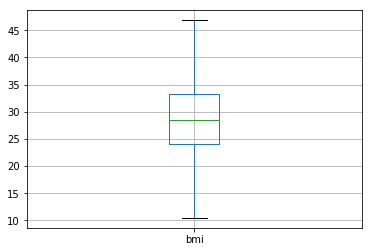

In [16]:
# AFTER ---- WITHOUTLIER OUTLIER BOXPLOT
selectedDataPd = selectedData.toPandas()
selectedDataPd.boxplot(column=[elementsToCheck])

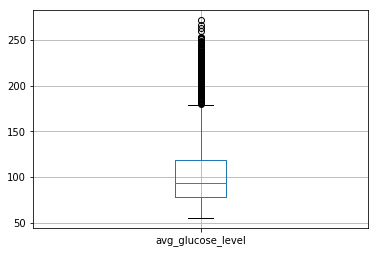

In [17]:
# avg_glucose_level
# BEFORE ---- WITH OUTLIER BOXPLOT
elementsToCheck = "avg_glucose_level"
selectedDataPd = selectedData.toPandas()
selectedDataPd.boxplot(column=[elementsToCheck])

In [18]:
# Print out the boxplot before removal
# APPLYING FILTERS

beforeCount = selectedData.select(elementsToCheck).count()
print("Number of instances before removal: ",beforeCount)


# CHECK NUMBER OF OUTLIER/EXTREMES
quantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " >" + str(UpperRange)
print("Number of Outliers / Extemes (BEFORE): ",selectedData.filter(query).count())


# REMOVE EXTREMES
extremeQuantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.05,0.995],0.0)
IQR = extremeQuantiles[1] - extremeQuantiles[0]

LowerRange = extremeQuantiles[0] - 1.5 * IQR
UpperRange = extremeQuantiles[1] + 1.5 * IQR

query = elementsToCheck + " !< " + str(LowerRange) + " or " + elementsToCheck + " !>" + str(UpperRange)
print("Ranges that kept: ", query)

selectedData = selectedData.filter(query)
print("Number of exteme removed: ",beforeCount - selectedData.select(elementsToCheck).count())


# Check Outliers
quantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

# Fill lower outliers

selectedData = selectedData.withColumn(elementsToCheck, when(col(elementsToCheck) < LowerRange, None).otherwise(col(elementsToCheck)))
print("Number of Lower Outlier assigned: ", selectedData.filter(elementsToCheck + " is null or " + elementsToCheck + " == 'Unknown'").count())
selectedData = selectedData.fillna(LowerRange, subset = elementsToCheck)

# Fill upper outliers

selectedData = selectedData.withColumn(elementsToCheck, when(col(elementsToCheck) > UpperRange, None).otherwise(col(elementsToCheck)))
print("Number of Upper Outlier assigned: ", selectedData.filter(elementsToCheck + " is null or " + elementsToCheck + " == 'Unknown'").count())
selectedData = selectedData.fillna(UpperRange, subset = elementsToCheck)

selectedData.filter(query).count()


# CHECK NUMBER OF OUTLIER/EXTREMES
quantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " >" + str(UpperRange)
print("Number of Outliers / Extemes (AFTER): ",selectedData.filter(query).count() )


print("Number of instances after removal: ",selectedData.select(elementsToCheck).count())


Number of instances before removal:  1419
Number of Outliers / Extemes (BEFORE):  191
Ranges that kept:  avg_glucose_level !< -225.71 or avg_glucose_level !>538.61
Number of exteme removed:  0
Number of Lower Outlier assigned:  0
Number of Upper Outlier assigned:  191
Number of Outliers / Extemes (AFTER):  0
Number of instances after removal:  1419


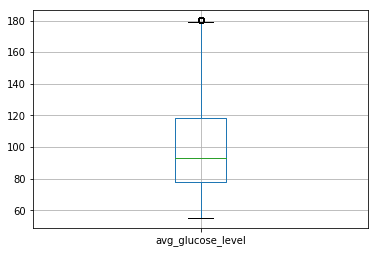

In [19]:
# AFTER ---- WITHOUTLIER OUTLIER BOXPLOT
selectedDataPd = selectedData.toPandas()
selectedDataPd.boxplot(column=[elementsToCheck])

In [20]:
#### 3.3 Feature Creation

In [21]:
#BMI Categories
selectedData = selectedData.withColumn("bmi_cate", selectedData["bmi"])

#Change tyep of bmi_cate
selectedData = selectedData.withColumn("bmi_cate",col("bmi_cate").cast(StringType()))
selectedData.printSchema()

from pyspark.sql.functions import when
selectedData = selectedData.withColumn("bmi_cate", when(selectedData.bmi < 18.5, "Underweight") \
                                       .when((selectedData.bmi >= 18.5) & (selectedData.bmi <= 24.9), "Normal") \
                                       .when((selectedData.bmi >= 25.0) & (selectedData.bmi <= 29.9), "Overweight") \
                                       .when(selectedData.bmi >= 30, "Obese"))

selectedData.select("bmi_cate").distinct().show()
selectedData = selectedData.drop("bmi")

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = false)
 |-- bmi: double (nullable = false)
 |-- smoking_status: string (nullable = false)
 |-- stroke: string (nullable = true)
 |-- bmi_cate: string (nullable = false)

+-----------+
|   bmi_cate|
+-----------+
| Overweight|
|Underweight|
|      Obese|
|     Normal|
+-----------+



In [22]:
#work Categories
selectedData = selectedData.withColumn("work_type_new", selectedData["work_type"])

#Change tyep of bmi_cate
selectedData = selectedData.withColumn("work_type_new",col("work_type_new").cast(StringType()))
selectedData.printSchema()

print("Existing Categories: ")
selectedData.select("work_type").distinct().show()

selectedData = selectedData.withColumn("work_type_new", when(selectedData.work_type == "children", "Never_worked") \
                                       .when(selectedData.work_type == "Never_worked", "Never_worked") \
                                       .when(selectedData.work_type == "Govt_job", "Govt_job") \
                                       .when(selectedData.work_type == "Self-employed", "Private") \
                                       .when(selectedData.work_type == "Private", "Private"))

print("New Categories: ")
selectedData.select("work_type_new").distinct().show()
selectedData = selectedData.drop("work_type")

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = false)
 |-- smoking_status: string (nullable = false)
 |-- stroke: string (nullable = true)
 |-- bmi_cate: string (nullable = true)
 |-- work_type_new: string (nullable = true)

Existing Categories: 
+-------------+
|    work_type|
+-------------+
| Never_worked|
|Self-employed|
|      Private|
|     children|
|     Govt_job|
+-------------+

New Categories: 
+-------------+
|work_type_new|
+-------------+
| Never_worked|
|      Private|
|     Govt_job|
+-------------+



In [23]:
#### 3.5 Data Formatting

In [24]:
from pyspark.ml.feature import StringIndexer

# GENDER
indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
selectedData = indexer.fit(selectedData).transform(selectedData)

# # work_type_new
indexer = StringIndexer(inputCol="work_type_new", outputCol="work_type_newIndex")
selectedData = indexer.fit(selectedData).transform(selectedData)

# # bmi_cate
indexer = StringIndexer(inputCol="bmi_cate", outputCol="bmi_cateIndex")
selectedData = indexer.fit(selectedData).transform(selectedData)

# # smoking_status
indexer = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")
selectedData = indexer.fit(selectedData).transform(selectedData)

# # ever_married
indexer = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
selectedData = indexer.fit(selectedData).transform(selectedData)

selectedData.select(["gender","genderIndex", "work_type_new","work_type_newIndex", "bmi_cate","bmi_cateIndex","smoking_status","smoking_statusIndex"]).show(10)
selectedData = selectedData.drop("gender", "work_type_new", "bmi_cate", "smoking_status", "ever_married")

+------+-----------+-------------+------------------+----------+-------------+---------------+-------------------+
|gender|genderIndex|work_type_new|work_type_newIndex|  bmi_cate|bmi_cateIndex| smoking_status|smoking_statusIndex|
+------+-----------+-------------+------------------+----------+-------------+---------------+-------------------+
|  Male|        1.0|      Private|               0.0|     Obese|          0.0|formerly smoked|                2.0|
|  Male|        1.0|      Private|               0.0|     Obese|          0.0|   never smoked|                1.0|
|Female|        0.0|      Private|               0.0|     Obese|          0.0|         smokes|                0.0|
|Female|        0.0|      Private|               0.0|    Normal|          2.0|   never smoked|                1.0|
|  Male|        1.0|      Private|               0.0|Overweight|          1.0|formerly smoked|                2.0|
|  Male|        1.0|      Private|               0.0|Overweight|          1.0|  

In [25]:
#### Section 4 Data Transformation ####

In [26]:
# 4.1 Data Reduction
### Feature Importance Evaluate
print("Number of Attributes: ",len(selectedData.columns))
selectedData.columns

Number of Attributes:  11


['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'stroke',
 'genderIndex',
 'work_type_newIndex',
 'bmi_cateIndex',
 'smoking_statusIndex',
 'ever_marriedIndex']

In [27]:
selectedData = selectedData.withColumn("id",col("id").cast(IntegerType())) \
    .withColumn("hypertension",col("hypertension").cast(IntegerType())) \
    .withColumn("heart_disease",col("heart_disease").cast(IntegerType()))\
    .withColumn("stroke",col("stroke").cast(IntegerType()))
selectedData.printSchema() 

root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- avg_glucose_level: double (nullable = false)
 |-- stroke: integer (nullable = true)
 |-- genderIndex: double (nullable = true)
 |-- work_type_newIndex: double (nullable = true)
 |-- bmi_cateIndex: double (nullable = true)
 |-- smoking_statusIndex: double (nullable = true)
 |-- ever_marriedIndex: double (nullable = true)



In [28]:
### Feature Importance Evaluate
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
assembler = VectorAssembler(inputCols=['id',
                             'age',
                             'hypertension',
                             'heart_disease',
                             'avg_glucose_level',
                             'genderIndex',
                             'work_type_newIndex',
                             'bmi_cateIndex',
                             'smoking_statusIndex',
                             'ever_marriedIndex'],
                              outputCol="features")

selectedData = assembler.transform(selectedData)

selectedData_test = selectedData.select("stroke","features")
rf = RandomForestClassifier(labelCol="stroke", featuresCol = "features")
model = rf.fit(selectedData_test)
model.featureImportances

SparseVector(10, {0: 0.1032, 1: 0.4331, 2: 0.0942, 3: 0.099, 4: 0.1384, 5: 0.0174, 6: 0.0072, 7: 0.025, 8: 0.0469, 9: 0.0355})

In [29]:
# Remove those less importance
print("Before: ", selectedData.columns)
selectedData = selectedData.drop("id", "genderIndex", "work_type_newIndex", "smoking_statusIndex", "ever_marriedIndex", "features")
print("After: ", selectedData.columns)

Before:  ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke', 'genderIndex', 'work_type_newIndex', 'bmi_cateIndex', 'smoking_statusIndex', 'ever_marriedIndex', 'features']
After:  ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke', 'bmi_cateIndex']


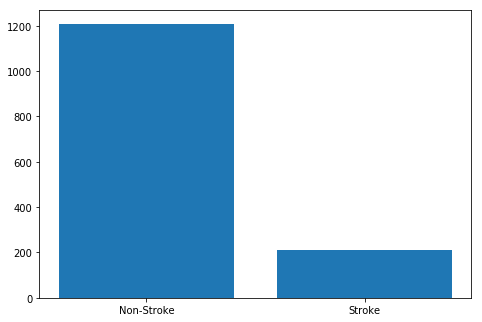

In [30]:
# 4.2 Data Projection
import matplotlib.pyplot as plt

#BEFORE
strokeData = selectedData.filter("stroke == 1")
nonStrokeData = selectedData.filter("stroke == 0")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xlab = ["Non-Stroke", "Stroke"]
x = [nonStrokeData.count(),strokeData.count()]

ax.bar(xlab,x)
plt.show()

In [31]:
# PROCESS
print("Non-Stroke: ", nonStrokeData.count())
print("Stroke: ", strokeData.count())

oversamplingStrokeData = strokeData.sample(True, 8.0).limit(nonStrokeData.count())
selectedData = nonStrokeData.union(oversamplingStrokeData)
print("Number of Instances after selection: ",selectedData.count())

Non-Stroke:  1210
Stroke:  209
Number of Instances after selection:  2420


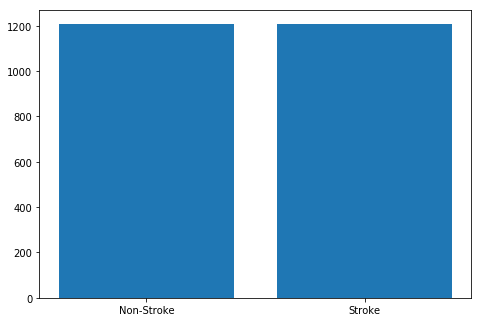

In [32]:
#AFTER
strokeData = selectedData.filter("stroke == 1")
nonStrokeData = selectedData.filter("stroke == 0")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xlab = ["Non-Stroke", "Stroke"]
x = [nonStrokeData.count(),strokeData.count()]

ax.bar(xlab,x)
plt.show()

In [33]:
#### Section 6 Data Mining Algorithms ####

In [34]:
# 6.2 Algorithm Analysis

# Prepare Data as Attribute and Label
selectedData.columns
assembler = VectorAssembler(inputCols=['age',
                             'hypertension',
                             'heart_disease',
                             'avg_glucose_level',
                             'bmi_cateIndex'],
                              outputCol="features")

finalData = assembler.transform(selectedData)

# 7.1 Train /Test Split
# Split Train / Test datasets
train_data,test_data = finalData.randomSplit([0.7,0.3])

print("Num of Train: ", train_data.count())
print("Num of Test: ", test_data.count())

Num of Train:  1686
Num of Test:  734


In [35]:
#Evaluation Function
def evaluation(data):
    tp = data[(data.prediction == 1) & (data.stroke == 1)].count()
    tn = data[(data.prediction == 0) & (data.stroke == 0)].count()
    fn = data[(data.prediction == 0) & (data.stroke == 1)].count()
    fp = data[(data.prediction == 1) & (data.stroke == 0)].count()
    
    print("Confusion Matrix")
    print("[" + str(tp) + "  " + str(fp))
    print(" " + str(fn) + "  " + str(tn) + "]")

In [36]:
# # Random Forest
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time

print("Random Forest ---")
start = time.time()
rfc = RandomForestClassifier(labelCol="stroke", featuresCol = "features")
rfc_model = rfc.fit(train_data)
rfc_predictions = rfc_model.transform(test_data)
end = time.time()
print("Time Elapsed: ", end - start)

binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
print("RFC Accuracy: ",binary_eval.evaluate(rfc_predictions))
evaluation(rfc_predictions)


Random Forest ---
Time Elapsed:  4.327666997909546
RFC Accuracy:  0.8828366298408172
Confusion Matrix
[329  102
 39  264]


In [37]:
from pyspark.ml.classification import NaiveBayes

print("Naive Bayes ---")
start = time.time()
nb = NaiveBayes(labelCol="stroke", featuresCol = "features")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)
end = time.time()
print("Time Elapsed: ", end - start)

print("NB Accuracy: ",binary_eval.evaluate(nb_predictions))
evaluation(nb_predictions)

Naive Bayes ---
Time Elapsed:  3.727915048599243
NB Accuracy:  0.18124851508671896
Confusion Matrix
[216  130
 152  236]


In [38]:
from pyspark.ml.classification import LogisticRegression

print("Logistic Regression ---")
start = time.time()
lr = LogisticRegression(labelCol="stroke", featuresCol = "features")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
end = time.time()
print("Time Elapsed: ", end - start)

print("NB Accuracy: ",binary_eval.evaluate(lr_predictions))
evaluation(lr_predictions)

Logistic Regression ---
Time Elapsed:  3.805750608444214
NB Accuracy:  0.8423987289142318
Confusion Matrix
[278  102
 90  264]


In [39]:
# 6.3 Parameter Tuning
number_of_tree = [20, 50, 75, 100]
max_depth = [5, 10, 20]

for nTrees in number_of_tree:
    for dpth in max_depth:
        print("Number of Trees: ", nTrees, " Depth: ", dpth, "-----------------")
        
        start = time.time()
        rfc = RandomForestClassifier(labelCol="stroke", featuresCol = "features", maxDepth = dpth, numTrees = nTrees)
        rfc_model = rfc.fit(train_data)
        rfc_predictions = rfc_model.transform(test_data)
        end = time.time()
        print("Time Elapsed: ", end - start)

        binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
        print("RFC Accuracy: ",binary_eval.evaluate(rfc_predictions))


Number of Trees:  20  Depth:  5 -----------------
Time Elapsed:  3.6035945415496826
RFC Accuracy:  0.8828366298408172
Number of Trees:  20  Depth:  10 -----------------
Time Elapsed:  4.767203092575073
RFC Accuracy:  0.9549068959372775
Number of Trees:  20  Depth:  20 -----------------
Time Elapsed:  5.831174612045288
RFC Accuracy:  0.9692994179139938
Number of Trees:  50  Depth:  5 -----------------
Time Elapsed:  2.928515911102295
RFC Accuracy:  0.8850454383464009
Number of Trees:  50  Depth:  10 -----------------
Time Elapsed:  5.7894673347473145
RFC Accuracy:  0.9569041043003088
Number of Trees:  50  Depth:  20 -----------------
Time Elapsed:  8.241316795349121
RFC Accuracy:  0.9709662330719886
Number of Trees:  75  Depth:  5 -----------------
Time Elapsed:  3.111769437789917
RFC Accuracy:  0.8861034390591591
Number of Trees:  75  Depth:  10 -----------------
Time Elapsed:  5.359618186950684
RFC Accuracy:  0.9582999227845095
Number of Trees:  75  Depth:  20 -----------------
Time E

In [40]:
#### Section 7 Data Mining ####
# 7.2 Data Mining Method

print("Random Forest --- Final Model")
start = time.time()
rfc = RandomForestClassifier(labelCol="stroke", featuresCol = "features", maxDepth = dpth, numTrees = nTrees)
rfc_model = rfc.fit(train_data)
rfc_predictions = rfc_model.transform(test_data)
end = time.time()
print("Time Elapsed: ", end - start)

binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
print("RFC Accuracy: ",binary_eval.evaluate(rfc_predictions))

tp = rfc_predictions[(rfc_predictions.prediction == 1) & (rfc_predictions.stroke == 1)].count()
tn = rfc_predictions[(rfc_predictions.prediction == 0) & (rfc_predictions.stroke == 0)].count()
fn = rfc_predictions[(rfc_predictions.prediction == 0) & (rfc_predictions.stroke == 1)].count()
fp = rfc_predictions[(rfc_predictions.prediction == 1) & (rfc_predictions.stroke == 0)].count()
    
print("Confusion Matrix")
print("[" + str(tp) + "  " + str(fp))
print(" " + str(fn) + "  " + str(tn) + "]" + "\n")

precision = float((tp)/(tp + fp))
recall = float((tp)/(tp + fn))

print("Precision: ",precision)
print("Recall: ",recall)
print("F1 :",float(2 * precision * recall / (precision + recall)))


Random Forest --- Final Model
Time Elapsed:  10.995705842971802
RFC Accuracy:  0.9748492813019719
Confusion Matrix
[366  47
 2  319]

Precision:  0.8861985472154964
Recall:  0.9945652173913043
F1 : 0.9372599231754162


(5,[0,1,2,3,4],[0.5762491288444395,0.04872763593050932,0.0363463405931887,0.26074914068739585,0.07792775394446663])


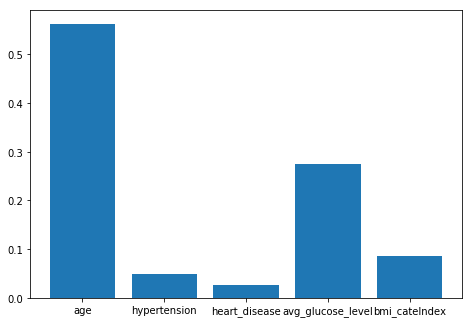

In [41]:
# Feature Importance 
print(rfc_model.featureImportances)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xlab = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi_cateIndex']
importance = [0.5629372269275104,0.04888393922270455,0.026654497640854542,0.27481496934045146,0.0867093668684791]

ax.bar(xlab,importance)
plt.show()